In [1]:
import torch
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
from torch.nn.functional import cosine_similarity
from torchvision import transforms
from PIL import Image
from model import DINOv2SegmentationModel,map_to_color,cityscapes_colors

In [2]:
def visualize_all(
    model, image, ground_truth, fixed_point=(112, 112), device="cuda"
):
    """
    可视化输入图像、分割预测、叠加图像、像素相似性和分类错误像素

    Args:
        model: DINOv2SegmentationModel 模型
        image: 输入图像张量 [1, 3, H, W]
        ground_truth: 真实标签张量 [1, H, W]
        fixed_point: 固定点坐标 (x, y)
        device: 计算设备 (如 "cuda" 或 "cpu")
    """
    # 将模型和图像转移到设备
    model.to(device)
    image = image.to(device)
    ground_truth = ground_truth.to(device)

    # 模型预测
    model.eval()
    with torch.no_grad():
        features = model.backbone(image)  # 提取多尺度特征
        feature_map = features[-1]       # 使用最后一层的特征图作为相似性计算基础
        predictions = model(image)       # 模型分割输出
        predictions = predictions.argmax(dim=1)  # 获取类别索引 [1, H, W]

    # 调整 Ground Truth 尺寸与预测图一致
    ground_truth_resized = F.interpolate(
        ground_truth.unsqueeze(0).float(),
        size=predictions.shape[1:],
        mode="nearest"
    ).squeeze(0).long()

    # 颜色映射
    predictions_cpu = predictions.cpu().numpy()
    ground_truth_resized_cpu = ground_truth_resized.cpu().numpy()
    predictions_colored = map_to_color(predictions_cpu[0], cityscapes_colors)
    ground_truth_colored = map_to_color(ground_truth_resized_cpu[0], cityscapes_colors)

    # 转换为 PyTorch 张量
    predictions_colored_tensor = torch.tensor(predictions_colored, device=predictions.device)
    ground_truth_colored_tensor = torch.tensor(ground_truth_colored, device=ground_truth_resized.device)
    predictions_colored_tensor = predictions_colored_tensor.permute(2, 0, 1).unsqueeze(0)
    ground_truth_colored_tensor = ground_truth_colored_tensor.permute(2, 0, 1).unsqueeze(0)

    # 分类错误像素
    misclassified_mask = (predictions_colored_tensor != ground_truth_colored_tensor)

    # 计算下采样倍数
    downsample_factor_h = image.shape[2] / feature_map.size(2)
    downsample_factor_w = image.shape[3] / feature_map.size(3)

    # 将 fixed_point 缩放到 feature_map 的坐标系
    fixed_point_rescaled = (
        int(fixed_point[0] / downsample_factor_w),
        int(fixed_point[1] / downsample_factor_h),
    )

    # 检查缩放后的坐标是否有效
    if fixed_point_rescaled[0] >= feature_map.size(3) or fixed_point_rescaled[1] >= feature_map.size(2):
        raise ValueError(f"Rescaled fixed point {fixed_point_rescaled} is out of bounds for feature map size {feature_map.size()}")

    # 提取固定点的特征
    fixed_feature = feature_map[:, :, fixed_point_rescaled[1], fixed_point_rescaled[0]]

    # 计算固定点与其他像素点的余弦相似性
    h, w = feature_map.size(2), feature_map.size(3)
    flattened_features = feature_map.view(feature_map.size(1), -1)  # [C, H*W]
    similarities = cosine_similarity(fixed_feature[0].unsqueeze(1), flattened_features, dim=0)  # [H*W]
    similarity_map = similarities.view(h, w)

    # 调整图像为 NumPy 格式
    similarity_map_resized = similarity_map.squeeze().cpu().numpy()
    misclassified_mask_resized = misclassified_mask.squeeze().cpu().numpy()
    img = image.squeeze(0).permute(1, 2, 0).cpu().numpy()
    img = img * np.array([0.229, 0.224, 0.225]) + np.array([0.485, 0.456, 0.406])  # 去标准化
    img = np.clip(img, 0, 1)
    pred_map = predictions_cpu.squeeze(0)

    # 创建布尔掩码
    mask = (pred_map == fixed_point[1])
    overlay = img.copy()
    overlay[mask] = [1.0, 0.0, 0.0]  # 红色叠加
    # -----------------------------------------------------------------
    # 打印插值前的图像维度信息
    print(f"Original Input Image Shape: {img.shape}")  # 原图
    print(f"Original Prediction Map Shape: {pred_map.shape}")  # 分割预测图
    print(f"Original Similarity Map Shape: {similarity_map_resized.shape}")  # 特征相似性图
    print(f"Original Misclassified Mask Shape: {misclassified_mask_resized.shape}")  # 分类错误掩码

    # 插值到目标大小
    target_size = (1024, 2048)  # 插值目标大小 (H, W)

    # 原始图像插值
    img_resized = F.interpolate(
        torch.tensor(img).permute(2, 0, 1).unsqueeze(0),  # [H, W, C] -> [1, C, H, W]
        size=target_size,
        mode="bilinear",
        align_corners=False
    ).squeeze(0).permute(1, 2, 0).numpy()  # [1, C, H, W] -> [H, W, C]

    # 分割预测图插值
    pred_map_resized = F.interpolate(
        torch.tensor(pred_map).unsqueeze(0).unsqueeze(0).float(),  # [H, W] -> [1, 1, H, W]
        size=target_size,
        mode="nearest"
    ).squeeze(0).squeeze(0).numpy()  # [1, 1, H, W] -> [H, W]

    # 特征相似性图插值
    similarity_map_resized = F.interpolate(
        torch.tensor(similarity_map_resized).unsqueeze(0).unsqueeze(0).float(),  # [H, W] -> [1, 1, H, W]
        size=target_size,
        mode="bilinear",
        align_corners=False
    ).squeeze(0).squeeze(0).numpy()  # [1, 1, H, W] -> [H, W]

    # 分类错误掩码插值
    misclassified_mask_resized = F.interpolate(
        torch.tensor(misclassified_mask_resized).unsqueeze(0).float(),  # [H, W] -> [1, 1, H, W]
        size=target_size,
        mode="nearest"
    ).squeeze(0).numpy()  # [1, 1, H, W] -> [H, W]

    # 可视化
    plt.figure(figsize=(15, 40))  # 调整高度以适应 5 行

    # 原图
    plt.subplot(5, 1, 1)
    plt.imshow(img_resized)
    plt.axis("off")
    plt.title("Input Image")

    # 分割预测图
    plt.subplot(5, 1, 2)
    plt.imshow(pred_map_resized, cmap="tab20")
    plt.colorbar()
    plt.axis("off")
    plt.title("Segmentation Prediction")

    # 叠加图像
    plt.subplot(5, 1, 3)
    plt.imshow(img_resized)
    plt.imshow(pred_map_resized, cmap="tab20", alpha=0.5)  # 透明度叠加
    plt.axis("off")
    plt.title("Overlay Prediction")

    # 特征相似性
    plt.subplot(5, 1, 4)
    plt.imshow(similarity_map_resized, cmap="viridis")
    plt.colorbar()
    plt.axis("off")
    plt.title("Pixel-Level Backbone Final Feature Similarity")

    # 分类错误像素
    plt.subplot(5, 1, 5)
    plt.imshow(img_resized)
    plt.imshow(misclassified_mask_resized.transpose(1, 2, 0), cmap="Reds", alpha=0.5)
    plt.axis("off")
    plt.title("Misclassified Pixels")

    plt.tight_layout()
    plt.show()


Original Input Image Shape: (224, 224, 3)
Original Prediction Map Shape: (224, 224)
Original Similarity Map Shape: (16, 16)
Original Misclassified Mask Shape: (3, 224, 224)


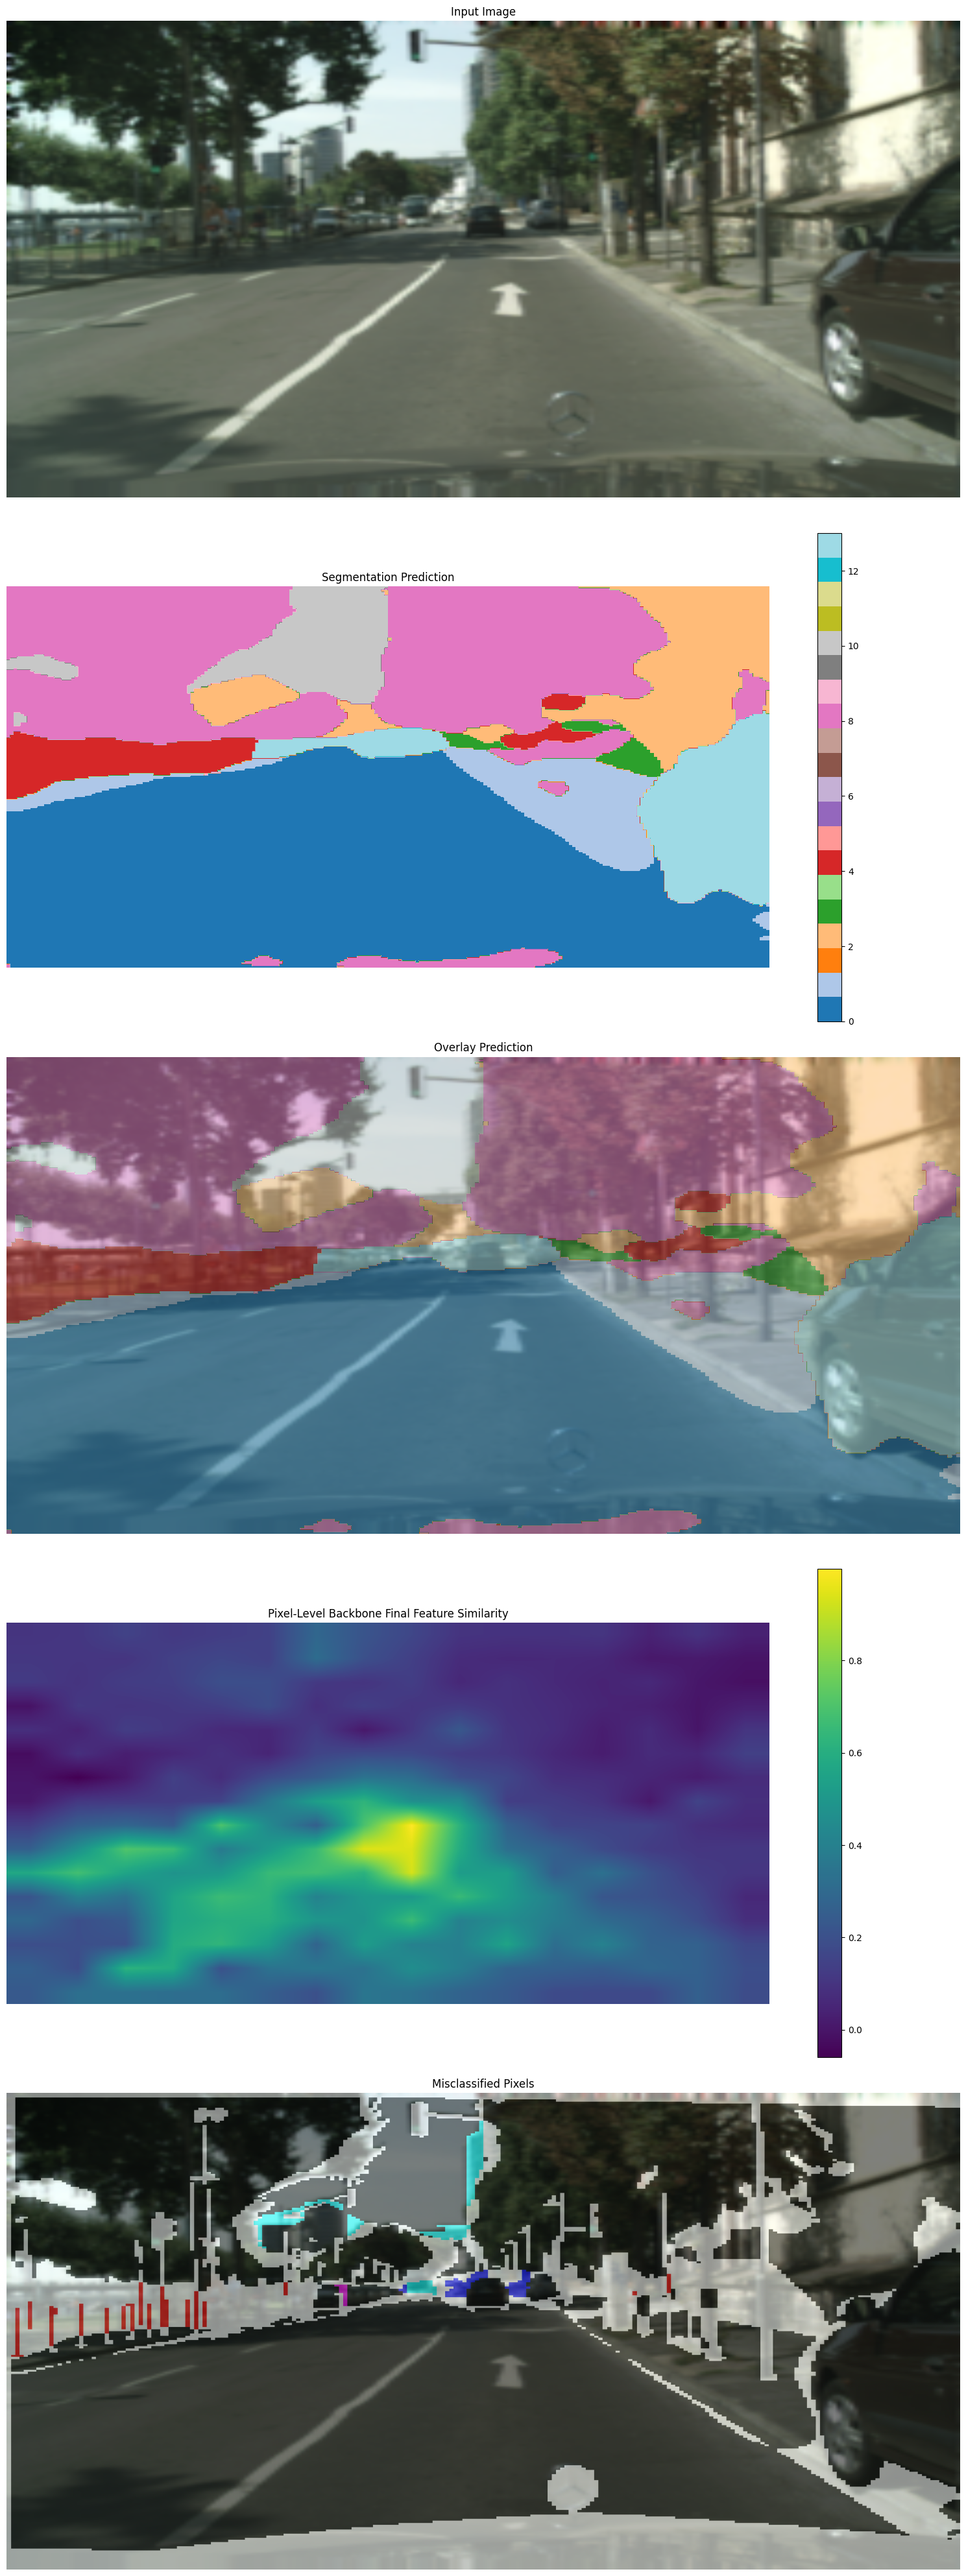

In [5]:
# 加载模型和数据
checkpoint_path = 'model/epoch_25_segmentation_checkpoint.pth'
img_path = 'dataset/image/cityscapes_val/frankfurt_000001_005703_leftImg8bit.png'
ground_truth_path = "dataset/label/cityscapes_19classes_val/frankfurt_000001_005703_gtFine_labelTrainIds.png"

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
checkpoint = torch.load(checkpoint_path, map_location=device)
model = DINOv2SegmentationModel(version='small', num_classes=19, pretrained=True)
model.load_state_dict(checkpoint['model_state_dict'])

# 示例输入图像和真实标签 (假设为 PIL 图像和标签)
preprocess = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

image = Image.open(img_path).convert("RGB")
image_tensor = preprocess(image).unsqueeze(0)  # [1, 3, H, W]


ground_truth_image = Image.open(ground_truth_path)
# 将真实标签转换为张量
ground_truth_tensor = torch.tensor(np.array(ground_truth_image), dtype=torch.long).unsqueeze(0)  # [1, H, W]
# 可视化结果
visualize_all(
    model, image_tensor, ground_truth_tensor, fixed_point=(112, 112), device="cuda"
)